In [ ]:
!pip install -q kaggle
!echo ' {"username":"keshavvel","key":"6dd3d1db00771ee02f8c33b9e0e33c97"} ' > kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip
!rm -rf chest-xray-pneumonia.zip kaggle.json

100% 2.29G/2.29G [00:17<00:00, 189MB/s]
100% 2.29G/2.29G [00:17<00:00, 142MB/s]


In [ ]:
from __future__ import print_function, division

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import random
import os
# CUDA_LAUNCH_BLOCKING=1
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDNN_HANDLE_ERROR'] = "1"
# torch.backends.cudnn.benchmark = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
g = torch.Generator()
g.manual_seed(0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
!nvidia-smi

Mon Nov 13 09:40:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    DEVICE = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    DEVICE = torch.device('cpu')

CUDA is available. Working on GPU


In [ ]:
!mv -n ./chest_xray/test/NORMAL/* ./chest_xray/val/NORMAL/
!mv -n ./chest_xray/test/PNEUMONIA/* ./chest_xray/val/PNEUMONIA/

In [ ]:
DIR_MAIN = 'chest_xray/'
DIR_TRAIN = DIR_MAIN + 'train/'
DIR_VAL = DIR_MAIN + 'val/'
DIR_TEST = DIR_MAIN + 'test/'

# Number of labels - 200
labels = os.listdir(DIR_TRAIN)

# Initialize labels encoder
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

# Create lists of files and labels for training (100,000 items)
files_train = []
labels_train = []
for label in labels:
    for filename in os.listdir(DIR_TRAIN + label):
        files_train.append(DIR_TRAIN + label + '/' + filename)
        labels_train.append(label)



In [ ]:
import os
import shutil

# Define the path to the original folder containing the subfolders
original_folder = DIR_VAL

# Define the path to the new folder where the files will be copied
new_folder = f"{DIR_VAL}/images"

if not os.path.exists(new_folder):
    os.makedirs(new_folder)


normal_folder = f'{DIR_VAL}/NORMAL'
pneumonia_folder = f'{DIR_VAL}/PNEUMONIA'

# Define the path to the val_annotations.txt file
val_file = f'{DIR_VAL}/val_annotations.txt'

# Write the heading to the val_annotations.txt file if it doesn't already exist
if not os.path.exists(val_file):
    with open(val_file, 'w') as f:
        f.write('')

# Loop through the normal folder and copy the files to the new folder
for file in os.listdir(normal_folder):
    if file.endswith('.jpeg'):
        file_path = os.path.join(normal_folder, file)
        new_file_path = os.path.join(new_folder, file)
        shutil.copy(file_path, new_file_path)
        with open(val_file, 'a') as f:
            f.write('{}\t{}\n'.format(file, 'NORMAL'))

# Loop through the pneumonia folder and copy the files to the new folder
for file in os.listdir(pneumonia_folder):
    if file.endswith('.jpeg'):
        file_path = os.path.join(pneumonia_folder, file)
        new_file_path = os.path.join(new_folder, file)
        shutil.copy(file_path, new_file_path)
        with open(val_file, 'a') as f:
            f.write('{}\t{}\n'.format(file, 'PNEUMONIA'))


In [ ]:
shutil.rmtree(normal_folder)
shutil.rmtree(pneumonia_folder)

In [ ]:
import os
import shutil

# Define the path to the original folder containing the subfolders
original_folder = DIR_TEST

# Define the path to the new folder where the files will be copied
new_folder = f"{DIR_TEST}/images"

if not os.path.exists(new_folder):
    os.makedirs(new_folder)


normal_folder = f'{DIR_TEST}/NORMAL'
pneumonia_folder = f'{DIR_TEST}/PNEUMONIA'

# Define the path to the test_annotations.txt file
test_file = f'{DIR_TEST}/test_annotations.txt'

# Write the heading to the test_annotations.txt file if it doesn't already exist
if not os.path.exists(test_file):
    with open(test_file, 'w') as f:
        f.write('')

# Loop through the normal folder and copy the files to the new folder
for file in os.listdir(normal_folder):
    if file.endswith('.jpeg'):
        file_path = os.path.join(normal_folder, file)
        new_file_path = f'{new_folder}/{file}'
        shutil.copy(file_path, new_file_path)
        with open(test_file, 'a') as f:
            f.write('{}\t{}\n'.format(file, 'NORMAL'))

# Loop through the pneumonia folder and copy the files to the new folder
for file in os.listdir(pneumonia_folder):
    if file.endswith('.jpeg'):
        file_path = os.path.join(pneumonia_folder, file)
        new_file_path = f'{new_folder}/{file}'
        shutil.copy(file_path, new_file_path)
        with open(test_file, 'a') as f:
            f.write('{}\t{}\n'.format(file, 'PNEUMONIA'))


In [ ]:
shutil.rmtree(normal_folder)
shutil.rmtree(pneumonia_folder)

# Data processing

In [ ]:
# Create lists of files and labels for validation
files_val = []
labels_val = []


In [ ]:
for filename in os.listdir(f'{DIR_VAL}images'):
    files_val.append(f'{DIR_VAL}images/{filename}')

temp_files_val = files_val

val_df = pd.read_csv(DIR_VAL + 'val_annotations.txt', sep='\t', names=["File", "Label"], usecols=["File", "Label"])
for f in temp_files_val:
    f = f.replace('images/','')
    l = val_df.loc[val_df['File'] == f[len(DIR_VAL):]]['Label'].values[0]
    labels_val.append(l)

# List of files for testing (10'000 items)
files_test = []
for filename in os.listdir(f'{DIR_TEST}/images'):
    files_test.append(f'{DIR_TEST}images/{filename}')
    files_test = sorted(files_test)


The first five files from the list of train images: ['chest_xray/train/NORMAL/NORMAL2-IM-1422-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1093-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-0983-0001-0002.jpeg', 'chest_xray/train/NORMAL/IM-0553-0001-0001.jpeg', 'chest_xray/train/NORMAL/IM-0391-0001.jpeg']

The first five labels from the list of train labels: ['NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL']

The first five files from the list of validation images: ['chest_xray/val/images/person94_bacteria_458.jpeg', 'chest_xray/val/images/person22_virus_54.jpeg', 'chest_xray/val/images/NORMAL2-IM-0073-0001.jpeg', 'chest_xray/val/images/person78_virus_140.jpeg', 'chest_xray/val/images/person64_virus_122.jpeg']

The first five labels from the list of validation labels: ['PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA']

The first five files from the list of test images: []


# Dataset

In [ ]:
class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transforms, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')

        if self.mode == 'train' or self.mode == 'val':
            x = self.transforms(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'test':
            x = self.transforms(pic)
            return x, self.files[index]

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    transforms.RandomErasing(p=0.5, scale=(0.06, 0.08), ratio=(1, 3), value=0, inplace=True)
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

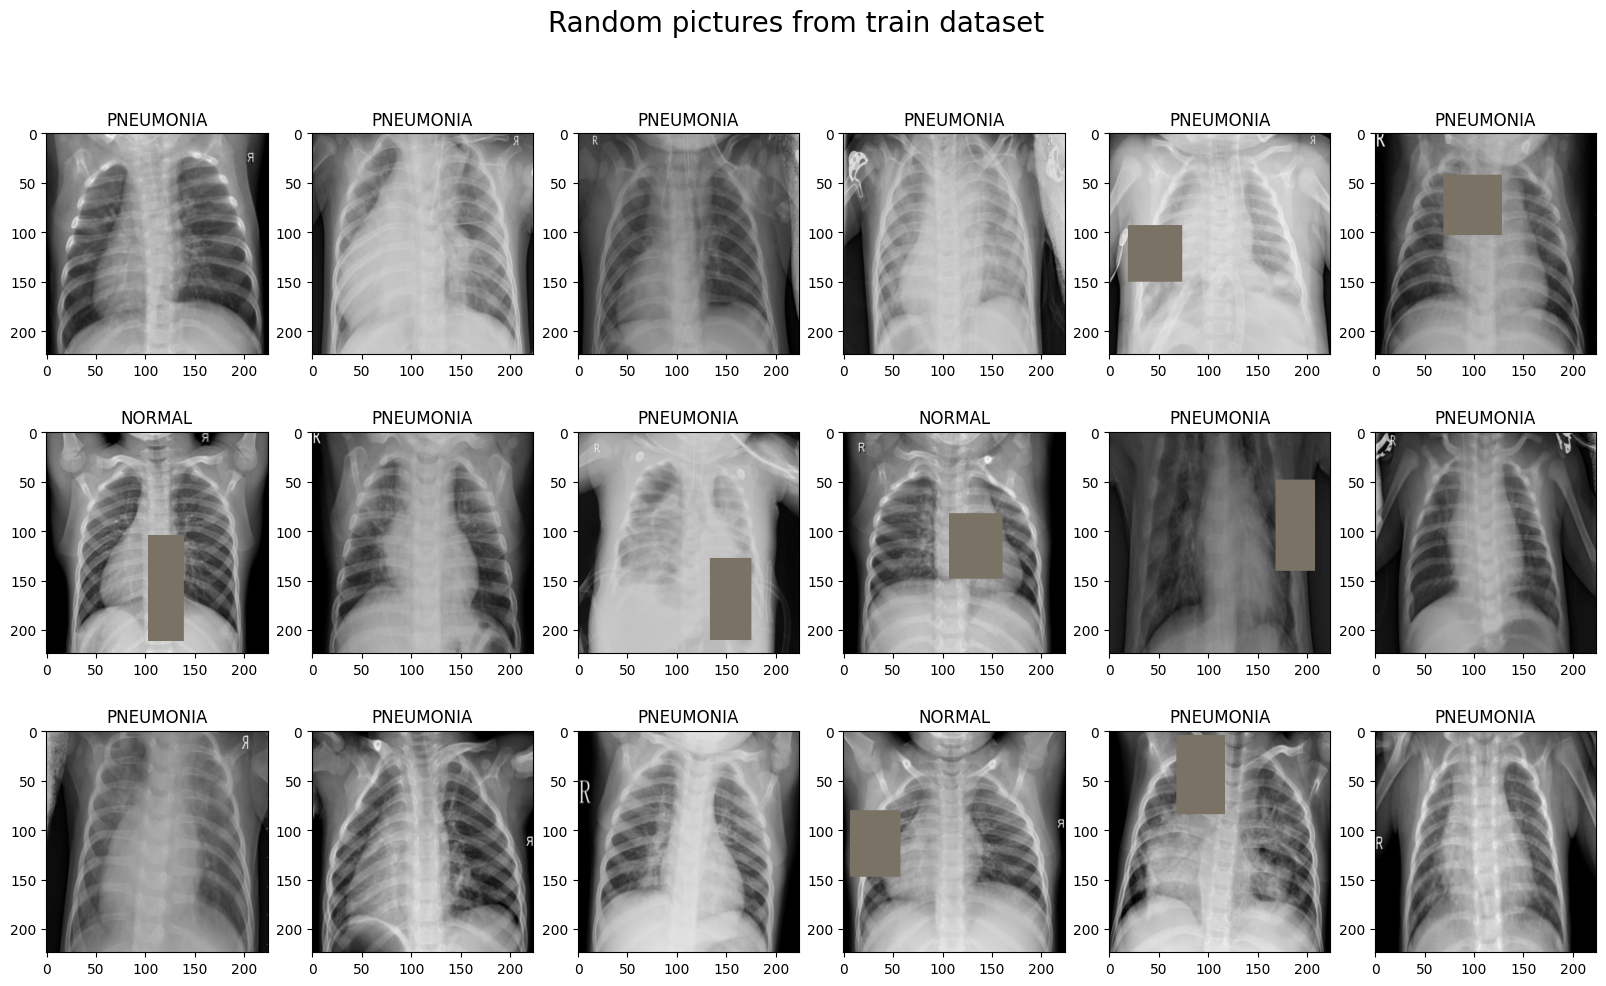

In [ ]:
train_dataset = ImagesDataset(files=files_train,
                              labels=labels_train,
                              encoder=encoder_labels,
                              transforms=transforms_train,
                              mode='train')

val_dataset = ImagesDataset(files=files_val,
                            labels=labels_val,
                            encoder=encoder_labels,
                            transforms=transforms_val,
                            mode='val')

test_dataset = ImagesDataset(files=files_test,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')

fig, axs = plt.subplots(3, 6, figsize=(20,11))
fig.suptitle('Pictures from train dataset', fontsize=20)
for ax in axs.flatten():
    n = np.random.randint(len(train_dataset))
    img = train_dataset[n][0]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array([0.2302, 0.2265, 0.2262])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.set_title(encoder_labels.inverse_transform([train_dataset[n][1]])[0])
    ax.imshow(img)

# Functions for training models

In [ ]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)
                print(epoch_items)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)
                print(epoch_items)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))

    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array

In [ ]:
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Training

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
num_epochs = 15

In [ ]:
num_epochs = 10

### Training DenseNet161

In [ ]:
print(dir(models))

['AlexNet', 'AlexNet_Weights', 'ConvNeXt', 'ConvNeXt_Base_Weights', 'ConvNeXt_Large_Weights', 'ConvNeXt_Small_Weights', 'ConvNeXt_Tiny_Weights', 'DenseNet', 'DenseNet121_Weights', 'DenseNet161_Weights', 'DenseNet169_Weights', 'DenseNet201_Weights', 'EfficientNet', 'EfficientNet_B0_Weights', 'EfficientNet_B1_Weights', 'EfficientNet_B2_Weights', 'EfficientNet_B3_Weights', 'EfficientNet_B4_Weights', 'EfficientNet_B5_Weights', 'EfficientNet_B6_Weights', 'EfficientNet_B7_Weights', 'EfficientNet_V2_L_Weights', 'EfficientNet_V2_M_Weights', 'EfficientNet_V2_S_Weights', 'GoogLeNet', 'GoogLeNetOutputs', 'GoogLeNet_Weights', 'Inception3', 'InceptionOutputs', 'Inception_V3_Weights', 'MNASNet', 'MNASNet0_5_Weights', 'MNASNet0_75_Weights', 'MNASNet1_0_Weights', 'MNASNet1_3_Weights', 'MaxVit', 'MaxVit_T_Weights', 'MobileNetV2', 'MobileNetV3', 'MobileNet_V2_Weights', 'MobileNet_V3_Large_Weights', 'MobileNet_V3_Small_Weights', 'RegNet', 'RegNet_X_16GF_Weights', 'RegNet_X_1_6GF_Weights', 'RegNet_X_32GF_

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_b0(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 36.8MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model_densenet161 = models.efficientnet_b0(pretrained=True)
# for param in model_densenet161.parameters():
#     param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier[1].in_features, out_features=2)
model_densenet161 = model_densenet161.to(DEVICE)

In [ ]:
# Count the number of trainable parameters
num_trainable_params = sum(p.numel() for p in model_densenet161.parameters() if p.requires_grad)

# Print the number of trainable parameters
print("Number of trainable parameters: {}".format(num_trainable_params))


Number of trainable parameters: 4010110


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]
5216


 10%|█         | 1/10 [02:27<22:05, 147.28s/it]

640
	| New lowest val loss for DenseNet161: 0.012522107036784292
Epoch: 2 | Learning rate: [0.0003]
5216


 20%|██        | 2/10 [04:37<18:16, 137.10s/it]

640
Epoch: 3 | Learning rate: [0.0003]
5216


 30%|███       | 3/10 [06:44<15:29, 132.77s/it]

640
Epoch: 4 | Learning rate: [3.267e-05]
5216


 40%|████      | 4/10 [08:52<13:05, 130.84s/it]

640
Epoch: 5 | Learning rate: [9.9e-05]
5216


 50%|█████     | 5/10 [10:59<10:46, 129.34s/it]

640
Epoch: 6 | Learning rate: [9.9e-05]
5216


 60%|██████    | 6/10 [13:06<08:33, 128.44s/it]

640
Epoch: 7 | Learning rate: [1.0781099999999999e-05]
5216


 70%|███████   | 7/10 [15:12<06:23, 127.79s/it]

640
Epoch: 8 | Learning rate: [3.267e-05]
5216


 80%|████████  | 8/10 [17:18<04:14, 127.34s/it]

640
Epoch: 9 | Learning rate: [3.267e-05]
5216


 90%|█████████ | 9/10 [19:26<02:07, 127.36s/it]

640
Epoch: 10 | Learning rate: [3.557763e-06]
5216


100%|██████████| 10/10 [21:31<00:00, 129.19s/it]

640


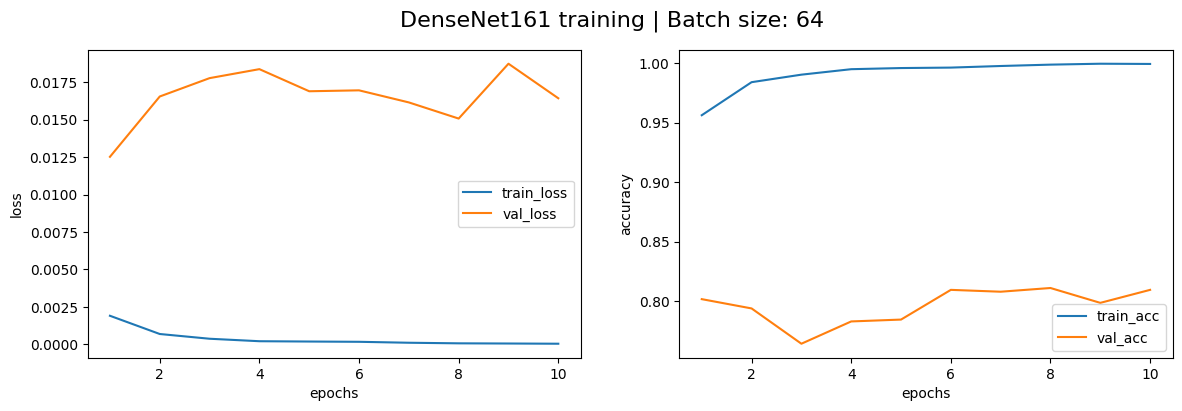


Training results:
	Min val loss 0.0125 was achieved during epoch #1
	Val accuracy during min val loss is 0.8016


In [ ]:
densenet161_training_results = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_dataloader,
                                        val_dataloader=val_dataloader)

model_densenet161, train_loss_array, train_acc_array, val_loss_array, val_acc_array = densenet161_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="DenseNet161",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

### Training ResNet152

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained ResNet-152 model
model_resnet152 = models.resnet152(pretrained=True)

# Freeze the initial convolutional layers
for param in model_resnet152.parameters():
    param.requires_grad = False

# Create additional layers with batch normalization and three dense layers
additional_layers = nn.Sequential(
    nn.Linear(model_resnet152.fc.in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 2)
)

# Update the model's architecture
model_resnet152.fc = additional_layers

# Move the model to the specified device
model_resnet152 = model_resnet152.to(DEVICE)


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:00<00:00, 280MB/s]


In [ ]:
# Count the number of trainable parameters
num_trainable_params = sum(p.numel() for p in model_resnet152.parameters() if p.requires_grad)

# Print the number of trainable parameters
print("Number of trainable parameters: {}".format(num_trainable_params))


Number of trainable parameters: 566722


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]
5216
640


 10%|█         | 1/10 [02:20<21:02, 140.30s/it]

	| New lowest val loss for ResNet152: 0.004990158206783235
Epoch: 2 | Learning rate: [0.0003]
5216


 20%|██        | 2/10 [04:37<18:26, 138.27s/it]

640
Epoch: 3 | Learning rate: [0.0003]
5216


 30%|███       | 3/10 [06:54<16:04, 137.80s/it]

640
Epoch: 4 | Learning rate: [3.267e-05]
5216


 40%|████      | 4/10 [09:11<13:45, 137.55s/it]

640
Epoch: 5 | Learning rate: [9.9e-05]
5216


 50%|█████     | 5/10 [11:29<11:27, 137.59s/it]

640
Epoch: 6 | Learning rate: [9.9e-05]
5216


 60%|██████    | 6/10 [13:47<09:11, 137.75s/it]

640
Epoch: 7 | Learning rate: [1.0781099999999999e-05]
5216


 70%|███████   | 7/10 [16:05<06:53, 137.85s/it]

640
Epoch: 8 | Learning rate: [3.267e-05]
5216


 80%|████████  | 8/10 [18:24<04:36, 138.42s/it]

640
Epoch: 9 | Learning rate: [3.267e-05]
5216


 90%|█████████ | 9/10 [20:46<02:19, 139.24s/it]

640
Epoch: 10 | Learning rate: [3.557763e-06]
5216


100%|██████████| 10/10 [23:07<00:00, 138.78s/it]

640


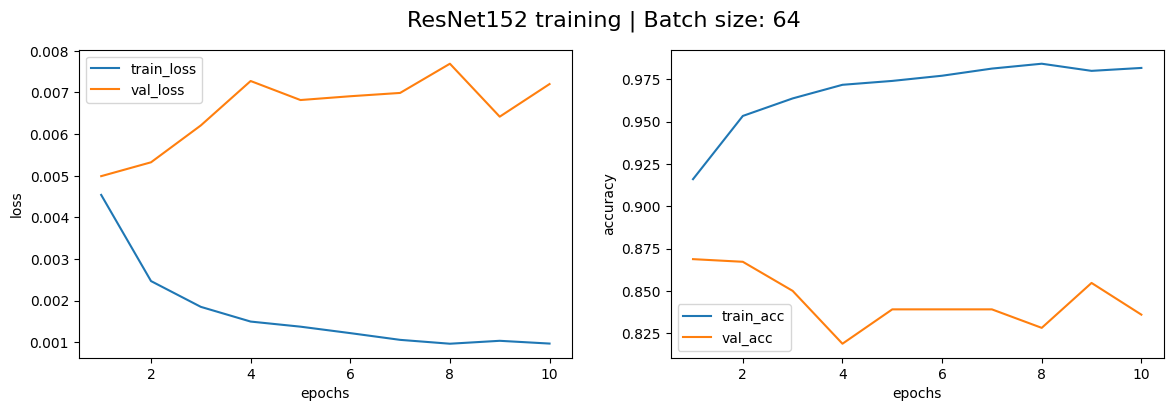


Training results:
	Min val loss 0.0050 was achieved during epoch #1
	Val accuracy during min val loss is 0.8688


In [ ]:
# model_resnet152 = models.resnet152(pretrained=True)
# for param in model_resnet152.parameters():
#     param.requires_grad = False
# model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 2)
# model_resnet152 = model_resnet152.to(DEVICE)

resnet152_training_results = training(model=model_resnet152,
                                      model_name='ResNet152',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader)

model_resnet152, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet152_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet152",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

### Training VGG19

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained VGG-19 model with batch normalization
model_vgg19_bn = models.vgg19_bn(pretrained=True)

# Freeze the initial convolutional layers
for param in model_vgg19_bn.parameters():
    param.requires_grad = False


print(model_vgg19_bn)



Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:04<00:00, 122MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# Create additional layers with batch normalization and three dense layers
additional_layers = nn.Sequential(
    nn.Linear(model_vgg19_bn.classifier[6].in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 2)
)

# Update the model's architecture
model_vgg19_bn.classifier[6] = additional_layers

# Move the model to the specified device
model_vgg19_bn = model_vgg19_bn.to(DEVICE)


In [ ]:
# model_vgg19_bn = models.vgg19_bn(pretrained=True)
# for param in model_vgg19_bn.parameters():
#     param.requires_grad = False
# model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=model_vgg19_bn.classifier[6].in_features, out_features=2)
# model_vgg19_bn = model_vgg19_bn.to(DEVICE)

vgg19_bn_training_results = training(model=model_vgg19_bn,
                                     model_name='VGG19_bn',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

model_vgg19_bn, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg19_bn_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG19_bn",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

### Training ensemble

In [ ]:
# In case we want to use saved weights

# model_vgg19_bn = models.vgg19_bn(pretrained = False)
# model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)

# model_resnet152 = models.resnet152(pretrained = False)
# model_resnet152.fc = torch.nn.Linear(in_features=2048, out_features=2)

# model_densenet161 = models.densenet161(pretrained = False)
# model_densenet161.classifier = torch.nn.Linear(in_features=2208, out_features=2)

# model_vgg19_bn.load_state_dict(torch.load('VGG19_bn_weights.pth'))
# model_resnet152.load_state_dict(torch.load('ResNet152_weights.pth'))
# model_densenet161.load_state_dict(torch.load('DenseNet161_weights.pth'))

In [ ]:
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights, vgg19_bn, VGG19_BN_Weights, densenet201, DenseNet201_Weights, resnext101_64x4d, ResNeXt101_64X4D_Weights

In [ ]:
# resnett_model = resnet50(weights=ResNet50_Weights.DEFAULT, progress=True)
# vgg19_model = vgg19_bn(weights=VGG19_BN_Weights.DEFAULT, progress=True)
# densenet_model = densenet201(weights=DenseNet201_Weights.DEFAULT, progress=True)
# resnext_model = resnext101_64x4d(weights= ResNeXt101_64X4D_Weights.DEFAULT, progress=True)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, modelA, modelB, modelC):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.classifier = nn.Linear(2 * 3, 2)

    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x = torch.cat((x1, x2, x3), dim=1)
        out = self.classifier(x)
        return out

ensemble_model = EnsembleModel(model_densenet161, model_resnet152, model_vgg19_bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True

ensemble_model = ensemble_model.to(DEVICE)

In [ ]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]



In [ ]:
visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs=num_epochs,
                           model_name="Ensemble model",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

# Classifying test dataset and saving results to csv-file

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

all_preds = []
all_files = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames = [f_name[30:] for f_name in all_files]
all_preds_decoded = encoder_labels.inverse_transform(all_preds)

submission_ensemble_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_ensemble_df.to_csv('test_predictions_ensemble.csv', header=False, index=False)
submission_ensemble_df.head(10)

In [ ]:
!cp test_predictions_ensemble.csv /content/nndl-project/ensemble/